## Import required packages

In [1]:
import os
import functools
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import gridspec

## Image Preprocessing

In [2]:
# Function to crop an image to a square shape
def crop_center(image):
    """Returns a cropped square image."""
    shape = image.shape
    new_shape = min(shape[1], shape[2])  # Determine the size of the new square
    offset_y = (
        max(shape[1] - shape[2], 0) // 2
    )  # Calculate vertical offset for cropping
    offset_x = (
        max(shape[2] - shape[1], 0) // 2
    )  # Calculate horizontal offset for cropping
    # Crop the image to a square shape
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, new_shape, new_shape
    )
    return image


# Function to load and preprocess images
@functools.lru_cache(
    maxsize=None
)  # Cache the result of loading images to improve performance
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
    # Cache image file locally.
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
    img = tf.io.decode_image(tf.io.read_file(image_path), channels=3, dtype=tf.float32)[
        tf.newaxis, ...
    ]
    img = crop_center(img)  # Crop the image to a square shape
    img = tf.image.resize(
        img, image_size, preserve_aspect_ratio=True
    )  # Resize the image
    return img


# Function to display multiple images in a grid
def show_n(images, titles=("",)):
    n = len(images)
    image_sizes = [image.shape[1] for image in images]  # Get sizes of the images
    # Calculate the size of the plot based on image sizes
    w = (image_sizes[0] * 6) // 320
    # Create a plot with appropriate size and grid specification
    plt.figure(figsize=(w * n, w))
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
    # Iterate through each image and plot it
    for i in range(n):
        plt.subplot(gs[i])
        plt.imshow(images[i][0], aspect="equal")  # Show the image
        plt.axis("off")  # Turn off axis
        plt.title(titles[i] if len(titles) > i else "")  # Set title if provided
    plt.show()

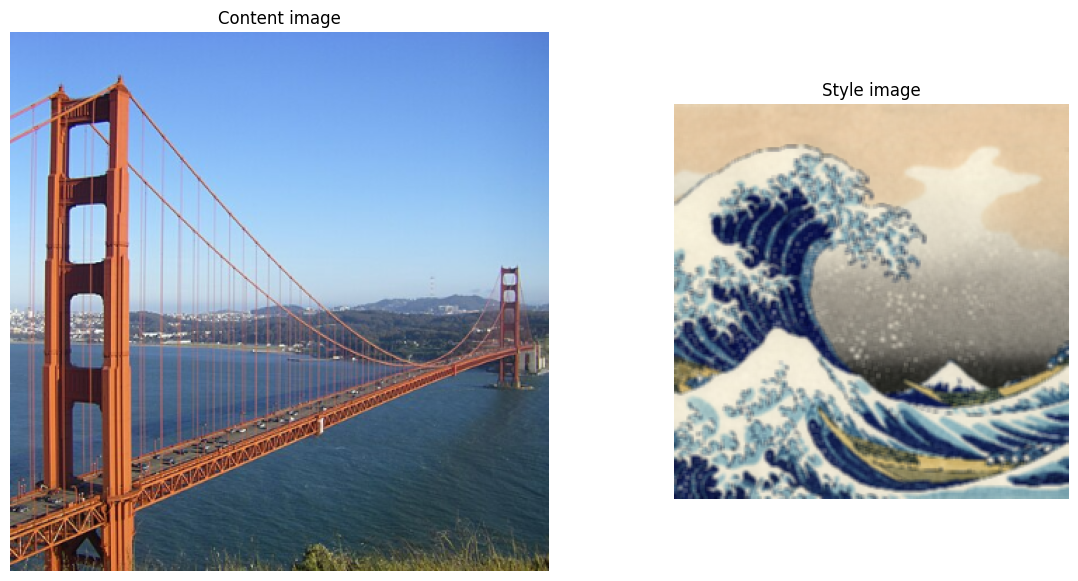

In [3]:
content_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg"
style_image_url = "https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg"
output_image_size = 384
content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)
content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3, 3], strides=[1, 1], padding="SAME")
show_n([content_image, style_image], ["Content image", "Style image"])

## Load the Model

In [4]:
hub_handle = "https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"
hub_module = hub.load(hub_handle)

## Image stylization

In [5]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

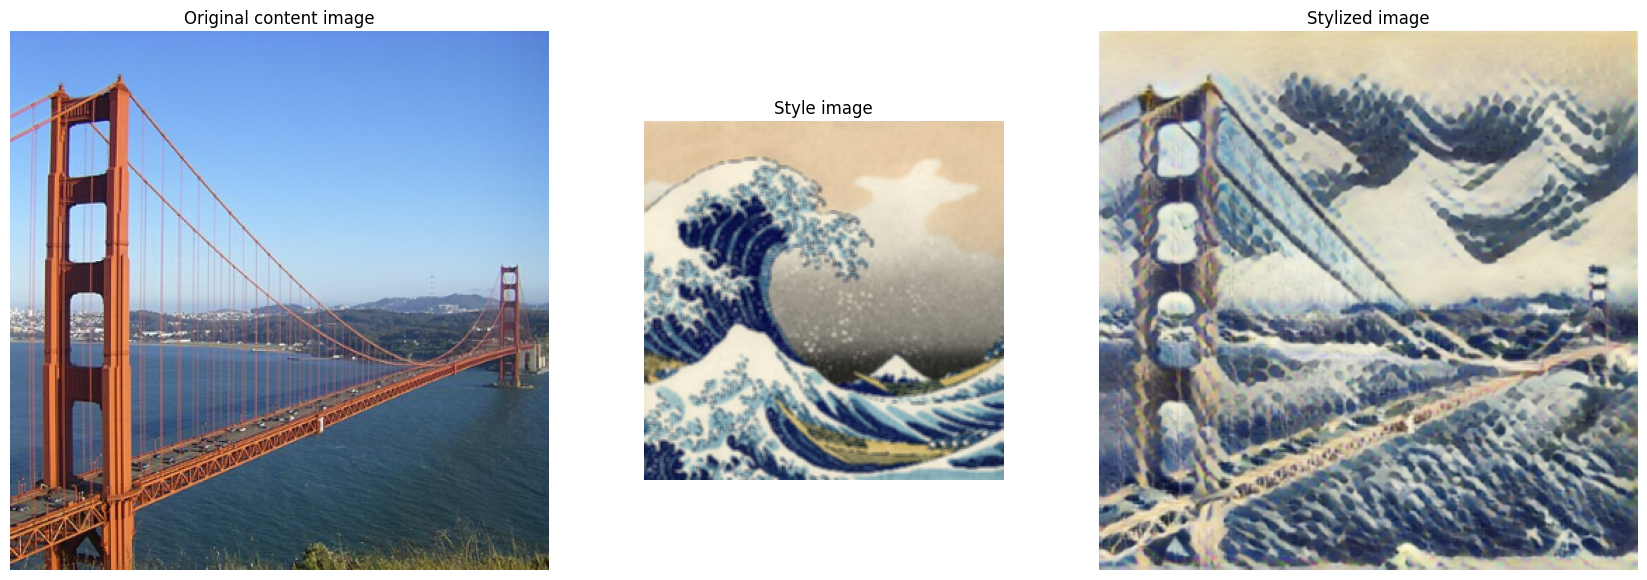

In [6]:
show_n(
    [content_image, style_image, stylized_image],
    titles=["Original content image", "Style image", "Stylized image"],
)